In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io.wavfile as wav
import os
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import glob
import math
import torch.nn as nn
import numpy as np
from bisect import bisect_left
import scipy as sp
import h5py

import wandb

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
data_folder = "../datasets/generated_dataset/"
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
dropout = 0.1
batch_size = 128
fs = 16000

max_shift = 500 # in samples
guess_grid_size = 100

wandb.init()

#f = h5py.File("../datasets/generated_dataset/generated_dataset_easy_big.hdf5","r")
f = h5py.File("../datasets/generated_dataset/generated_dataset_easy.hdf5","r")


X = f['input']
y = f['gt']

# f_test = h5py.File("../datasets/generated_dataset/generated_dataset_hard.hdf5","r")
# X_test = f_test['input']
# y_test = f_test['gt']

#X = torch.load(os.path.join(data_folder,"input2.pt"))
#y = torch.load(os.path.join(data_folder,"gt2.pt"))
#X_test = torch.load(os.path.join(data_folder,"input.pt"))
#y_test = torch.load(os.path.join(data_folder,"gt.pt"))

class custom_dataset(Dataset):

    def __init__(self, X, y, idx_min=0,dataset_len=len(X)):
        self.X = X
        self.y = y
        self.dataset_len = dataset_len
        self.idx_min = idx_min

    def __getitem__(self, idx):
        return self.X[idx + self.idx_min],self.y[idx + self.idx_min]

    def __len__(self):
        return self.dataset_len

split_i = int(X.shape[0]*0.9)
dataset = custom_dataset(X,y, 0, split_i)
#dataset_test = custom_dataset(X_test,y_test, 0 ,X_test.shape[0])
dataset_test = custom_dataset(X,y, split_i, X.shape[0] - split_i)
#dataset, dataset_test = torch.utils.data.random_split(dataset, [0.98,0.02])
train_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/er6236te/.netrc


In [3]:

cnn_output_size_at_factor_1 = 576
factor = 15
class Block(nn.Module):
    def __init__(self,size):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.l = nn.Linear(size,2*size)
        self.l2 = nn.Linear(2*size,size)
        self.act = nn.GELU()
        #self.ln = nn.LayerNorm(size)
        self.apply(self._init_weights)
        
        
        
        

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.002)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.002)
            
    def forward(self, x):
        x = self.dropout(x)
        #return x + self.act(self.l(self.ln(x)))
        return x + self.l2(self.act(self.l(x)))

class Classifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.thinker = nn.Sequential(
            #nn.Dropout(dropout),
            Block(cnn_output_size_at_factor_1*factor),
            #nn.Dropout(dropout),
            #Block(cnn_output_size_at_factor_1*factor),
            #nn.Dropout(dropout),
            #Block(cnn_output_size_at_factor_1*factor),
        )
        

        self.cnn = nn.Sequential(
            nn.Conv1d(4,48*factor, 50,stride=5),
            nn.GELU(),
            nn.Conv1d(48*factor,48*factor, 50,stride=5),
            nn.GELU(),
            nn.Conv1d(48*factor,48*factor, 30,stride=5),
            nn.GELU(),
            nn.Flatten(),
        )
        self.compress = nn.Sequential(
            #nn.Dropout(dropout),
            nn.Linear(cnn_output_size_at_factor_1*factor, guess_grid_size),
            #nn.GELU(),
            #nn.Linear(10*factor, guess_grid_size),
        )
        
        self.apply(self._init_weights)
        
        
        
        

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.002)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.002)
        
                
    def forward(self, x):
        x = self.cnn(x)
        
        x = self.thinker(x)
        return self.compress(x)
    
model = Classifier().to(device)

In [4]:
loss_fn = torch.nn.CrossEntropyLoss()


def y_to_class_gt(y, guess_grid_size, max_shift) :
    y[y.abs() > max_shift] = max_shift*y[y.abs() > max_shift].sign()

    bin_width = max_shift*2/guess_grid_size
    y = (y/bin_width).round() + guess_grid_size // 2 
    y[y == guess_grid_size] = guess_grid_size - 1
    return y.long()
    

#loss_fn = torch.nn.HuberLoss(delta=10)
def augment_switch(X,y):
    flips = torch.rand(y.shape[0]) < 0.5
    X[flips] = torch.stack([X[flips,:,:,1], X[flips,:,:,0]], dim=3)
    y[flips] = -y[flips]
    return X,y

def augment_shift(X,y, common_shift=True):
    X = torch.complex(X[:,0],X[:,1])

    #augment 1, multiply each of the vectors with phase
    

    max_shift = 1000 # number of samples to max_shift
    sample_length = 10000


    imag_unit = torch.complex(torch.tensor(0.0),torch.tensor(1.0))
    if common_shift:
        sample_shift = (torch.rand(X.shape[0],1,1)*2 - 1)*max_shift
        phase_shift = (-sample_shift/sample_length*2*torch.pi*imag_unit*torch.arange(X.shape[1]).unsqueeze(1)).exp()
        new_abf = X*phase_shift
        X = torch.stack([torch.real(new_abf),torch.imag(new_abf)], dim=1)
        
    else:
        sample_shift = (torch.rand(X.shape[0],1,2)*2 - 1)*max_shift
        phase_shift = (-sample_shift/sample_length*2*torch.pi*imag_unit*torch.arange(X.shape[1]).unsqueeze(1)).exp()
        new_abf = X*phase_shift
        X = torch.stack([torch.real(new_abf),torch.imag(new_abf)], dim=1)
        y = y + (sample_shift[:,:,0] - sample_shift[:,:,1]).to(int)
    return (X,y)

def augment_amp(X,y):
    amp_max = 3
    amp_min = 0.2
    amp_change_factor = torch.rand(X.shape)*(amp_max - amp_min) + amp_min
    X = X*amp_change_factor
    return (X,y)

def train(dataloader, model, loss_fn, optimizer):
    save_loss_to_file = []
    size = len(dataloader.dataset)
    model.train()
    
    n_batch_before_print = 10
    print_loss = 0
    for batch, (X,y) in enumerate(dataloader):
        
        X,y = augment_shift(X,y)
        X,y = augment_amp(X,y)
        X,y = augment_switch(X,y)
        
        # Compute prediction error
        X = torch.concatenate([X[:,:,:,0], X[:,:,:,1]], dim=1)
        X /= 1e6
        X = X.to(device)
        y = y_to_class_gt(y.squeeze(1), guess_grid_size, max_shift)
        #y = (y).to(int).squeeze(1) + guess_grid_size // 2
        #y = (y + 3*torch.randn(y.shape)).to(int).squeeze(1) + guess_grid_size // 2

        #add noise to answer
        

        y = y.to(device)
        pred = model(X)
        

        loss = loss_fn(pred, y)
        

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print_loss += loss.detach()/n_batch_before_print
        if batch % n_batch_before_print == 0:
            if batch == 0:
                print_loss = 0 
                continue
            wandb.log({"loss":loss})
            loss, current = print_loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print_loss = 0
            save_loss_to_file.append((loss, current))
    return save_loss_to_file

def test(dataloader, model, loss_fn):
    model.eval() # regression on dropout is not great
    
    with torch.no_grad():
        #model.train()
        print_loss = 0
        counter = 0
        for batch, (X,y) in enumerate(dataloader):
            
            # Compute prediction error
            X = torch.concatenate([X[:,:,:,0], X[:,:,:,1]], dim=1)
            X /= 1e6
            X = X.to(device)
            y = y_to_class_gt(y.squeeze(1), guess_grid_size, max_shift)
            #y = y.to(int).squeeze(1) + guess_grid_size // 2
            y = y.to(device)
            pred = model(X)
            

            loss = loss_fn(pred, y)
            
            print_loss += loss.detach()
            counter += 1
        loss = print_loss.item()/counter
        wandb.log({"Test_loss":loss})
        print(f"Test loss: {loss:>7f}")
        print_loss = 0
epochs = 200




In [5]:
wandb.watch(model, log_freq=50)
schedule_steps = 0
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5/10**schedule_steps)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10)
for t in range(epochs):
    losses = np.zeros((0,2))
    print(f"Epoch {t+1}\n-------------------------------")
    #torch.save(model, "model_musan_epoch_" + str(t)+ ".pth")

    loss_to_file = test(test_dl, model, loss_fn)
    loss_to_file = train(train_dl, model, loss_fn, optimizer)
    if t < schedule_steps:
        scheduler.step()
     
    #losses = np.concatenate([losses,np.array(loss_to_file
    # )])
    #np.save("losses", losses)
print("Done!")

Epoch 1
-------------------------------
Test loss: 4.605199
loss: 4.449162  [ 1280/ 2880]
loss: 3.923992  [ 2560/ 2880]
Epoch 2
-------------------------------
Test loss: 3.850060
loss: 3.894507  [ 1280/ 2880]
loss: 3.810418  [ 2560/ 2880]


KeyboardInterrupt: 

In [ ]:
#plt.plot(dataset_test[10000][0][0,:,0]/1e6)

#model = torch.load("model_class.pth")
#torch.save(model, "model_class.pth")
#next(iter(train_dl))[0]

tensor([False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False,  True, False,
         True, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,  True,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False,  True, False, False, False, False, False],

<Figure size 432x288 with 0 Axes>

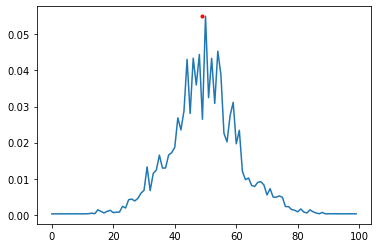

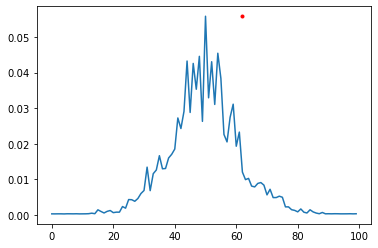

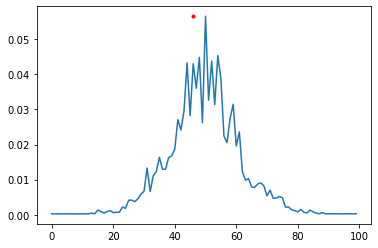

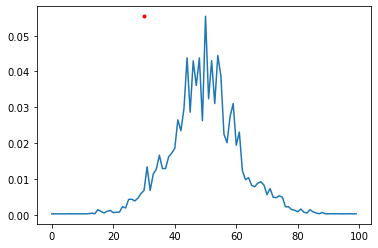

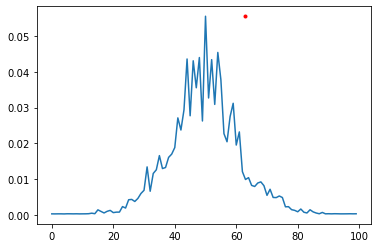

In [6]:
(X,y) = next(iter((test_dl)))

plt.figure()
# Compute prediction error
X = torch.concatenate([X[:,:,:,0], X[:,:,:,1]], dim=1)
X /= 1e6
X = X.to(device)
#y = y.to(int).squeeze(1) + guess_grid_size // 2
y = y_to_class_gt(y.squeeze(1), guess_grid_size, max_shift)
y = y.to(device)
pred = model(X)

#y.shape

pmin = int(torch.randint(100,(1,)))
pmax = pmin + 5
for i in range(pmin,pmax):
    plt.figure()
    plt.plot(pred[i].cpu().detach().softmax(dim=0))
    #print(pred[i].cpu().detach().softmax(dim=0).max())
    plt.plot(y[i].cpu().detach(), pred[i].cpu().detach().softmax(dim=0).max(),'r.')
#print(torch.argmax(pred[pmin:pmax], dim=1))

#temp = torch.zeros(pred.shape).to(device)
#temp[torch.arange(len(y)),y] = 1
#plt.plot(temp[2].cpu().detach())
#pred.shape
loss = loss_fn(pred, y)
#print(loss)
#pred - y
#pred


#pred.shape
res = pred.argmax(dim = 1) - y

res.abs() < 2

#plt.hist((pred.argmax(dim=1) - y).cpu().detach(),50)

In [7]:
#(X,y) = next(iter((test_dl)))
reses = torch.zeros(0)
for X,y in test_dl:
    # Compute prediction error
    X = torch.concatenate([X[:,:,:,0], X[:,:,:,1]], dim=1)
    X /= 1e6
    X = X.to(device)
    #y = y.to(int).squeeze(1) + guess_grid_size // 2
    y = y_to_class_gt(y.squeeze(1), guess_grid_size, max_shift)
    y = y.to(device)
    pred = model(X)
    res = pred.argmax(dim = 1) - y

    
    reses = torch.concatenate([reses, res.to("cpu").detach()])

plt.hist(reses,50)

(reses.abs() < 5).sum()/reses.numel()

tensor(0.3562)

Error in callback <function flush_figures at 0x7f69400df760> (for post_execute):


KeyboardInterrupt: 

In [ ]:
(reses.abs() < 2).sum()/reses.numel()

tensor(0.8353)

In [ ]:
#[i for i in range(10,0,-1)]


a = torch.zeros(2,1000)
a[:,:] = torch.log(torch.tensor(0.002))
#a[:,1] = torch.log(torch.tensor(0.002))
b = torch.ones(2,dtype=int)
loss_fn(a,b)
res = pred.argmax(dim = 1) - y

res.abs() < 5


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

(3200,)

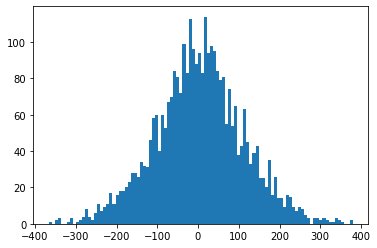

In [ ]:
y = f['gt']

plt.hist(y[:,0],100)
y[:,0].shape